# REINFORCE with baseline for continuous action space

This is an implementation of REINFORCE with baseline with modifications to deal with bounded continuous action spaces. See Sutton & Barto, Section 13.7.

We make the following changes to the previous notebook:

* Separate network for policy and value function
  
* Adjust the policy network to output means and standard deviations of a normal distribution

* Use of truncated normal distribution for bounded action space

* Use of hyper-parameters as given in the PPO paper, don't do hyper-parameter search anymore

* Set up training and evaluation on the Mujoco environments used in the PPO paper, to be used as a comparison for our PPO implementation, and run them for 10k episodes

* Evaluation of the random policy

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import RescaleAction

import numpy as np

import torch
from torch import nn

from torchrl.modules import TruncatedNormal

import pickle

import matplotlib.pyplot as plt

import time

In [19]:
# The policy needs to be modified to return a mean tensor and a standard deviations tensor
# - use logits as mean
# - standard deviations separate
# - no dependencies between dimensions of multi-variate normal distribution
class Policy(nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.Tanh(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Tanh(),
            nn.Linear(n_hidden2, n_out),
        )
        # self.sm = nn.Softmax(dim=0) # probabilities to choose an action
        # self.lsm = nn.LogSoftmax(dim=0) # for log probabilities used in the gradient for REINFORCE

        # From PPO, page 6: 
        # "To represent the policy, we used a fully-connected MLP with two hidden layers of 64 units,
        # and tanh nonlinearities, outputting the mean of a Gaussian distribution, with variable standard
        # deviations, following [Sch+15b; Dua+16]."
        # (See [Sch+15b] (Trust Region Policy Optimization) on page 15.)
        # Initialization of the standard deviations is not fully clear here, 
        # but to initialize them to 1 seems a reasonable first guess.
        self.log_stddevs = nn.Parameter(torch.zeros(n_out))
    
    def forward(self, x): 
        logits = self.net(x)
        # probs = self.sm(logits)
        # scores = self.lsm(logits)
        # return probs, scores, logits # we include the logits in the output for use in the state-value function
        stddevs = torch.exp(self.log_stddevs)
        return logits, stddevs
    
class Value(nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.Tanh(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Tanh(),
            nn.Linear(n_hidden2, 1), # same as Policy, but output is only one number
        )
    
    def forward(self, x): 
        logit = self.net(x)
        return logit

In [ ]:
envs = [
    # Continuous environments in Gymnasium:
    # "Pendulum-v1",
    # "MountainCarContinuous-v0",
    # "BipedalWalker-v3",
    # "LunarLander-v3",
    # "CarRacing-v3", # image input
    
    # Mujoco environments used by PPO (with updated version numbers):
    "HalfCheetah-v5",
    "Hopper-v5",
    "InvertedDoublePendulum-v5",
    "InvertedPendulum-v5",
    "Reacher-v5",
    "Swimmer-v5",
    "Walker2d-v5"
]

# Have a look at environment specifications
for env_name in envs:
    env = gym.make(env_name, continuous=True) if env_name in ["LunarLander-v3", "CarRacing-v3"] else gym.make(env_name)
    print("\nEnv name: {}, \n- Observation space: {} \n- Action space:      {} \n- Reward threshold: {}".format(env_name, env.observation_space, env.action_space, env.spec.reward_threshold))
    # The observation spaces are all from -inf to +inf (with various dimensions)

# We see that the action spaces are not always [-1, 1], but we don't want to change the initialization of the policy for these cases,
# so we will use https://gymnasium.farama.org/api/wrappers/action_wrappers/#gymnasium.wrappers.RescaleAction to bring the action space coordinates to [-1, 1] 
# Also note that not all environments have a reward_threshold


Env name: HalfCheetah-v5, 
- Observation space: Box(-inf, inf, (17,), float64) 
- Action space:      Box(-1.0, 1.0, (6,), float32) 
- Reward threshold: 4800.0

Env name: Hopper-v5, 
- Observation space: Box(-inf, inf, (11,), float64) 
- Action space:      Box(-1.0, 1.0, (3,), float32) 
- Reward threshold: 3800.0

Env name: InvertedDoublePendulum-v5, 
- Observation space: Box(-inf, inf, (9,), float64) 
- Action space:      Box(-1.0, 1.0, (1,), float32) 
- Reward threshold: 9100.0

Env name: InvertedPendulum-v5, 
- Observation space: Box(-inf, inf, (4,), float64) 
- Action space:      Box(-3.0, 3.0, (1,), float32) 
- Reward threshold: 950.0

Env name: Reacher-v5, 
- Observation space: Box(-inf, inf, (10,), float64) 
- Action space:      Box(-1.0, 1.0, (2,), float32) 
- Reward threshold: -3.75

Env name: Swimmer-v5, 
- Observation space: Box(-inf, inf, (8,), float64) 
- Action space:      Box(-1.0, 1.0, (2,), float32) 
- Reward threshold: 360.0

Env name: Walker2d-v5, 
- Observation spac

In [ ]:
seed = 42
env_name = "InvertedDoublePendulum-v5"

n_hidden1 = 64 
n_hidden2 = 64

# Sutton & Barto use a separate learning rate to update the state-value function parameters
# We will establish a baseline for all environments for the (fixed) parameters as used in the PPO paper
# (as far as they are used by the algorithm here)
# See Table 3, page 10
gamma = 0.99
alpha_value = 3e-4
alpha = 3e-4

n_episodes = 1_000_000
print_every_n_episodes = int(n_episodes / 20)

In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)

# Initialise the environment
env = gym.make(env_name, continuous=True) if env_name in ["LunarLander-v3", "CarRacing-v3"] else gym.make(env_name)
env = RescaleAction(env, min_action=-1, max_action=1)

# Reset the environment to generate the first observation
observation, info = env.reset(seed=seed)
observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)

policy = Policy(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_out=env.action_space.shape[0])

# The state-value function maps states to a single number. From PPO: "We don’t share parameters between the policy and value function [...]". 
value = Value(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2)

# Sutton & Barto use separate gradient update steps with separate learning rates for the policy and the state-value function
# Adam with default parameters instead of SGD
optimizer = torch.optim.Adam(policy.parameters(), lr=alpha, maximize=True)
optimizer_value = torch.optim.Adam(value.parameters(), lr=alpha_value, maximize=True)


all_episode_rewards = []

for i_episode in range(1, n_episodes+1):
    
    rewards = [] # T rewards from 1 to T
    observations = [observation] # T observations from 0 to T-1, the policy expects tensors as input
    actions = [] # T actions from 0 to T-1

    # roll-out of one episode following the policy
    done = False
    while not done:
        
        # probabilities for actions
        # Change 1: The policy network outputs means and standard deviations
        pred_means, pred_stddevs = policy(observation)
        
        # sample an action according to the probabilities
        # Change 2: We use the truncated normal distribution on the continuous action space, not the categorical distribution for a discrete set of actions
        TN = TruncatedNormal(loc=pred_means,
                             scale=pred_stddevs,
                             low=env.action_space.low,
                             high=env.action_space.high,
                             tanh_loc=False)
        action = TN.sample()

        # step (transition) through the environment with the action
        # receiving the next observation, reward and if the episode has terminated or truncated
        observation, reward, terminated, truncated, info = env.step(action.detach().numpy())
        observation = torch.tensor(observation, requires_grad=False, dtype=torch.float32)
        done = terminated or truncated

        # build up one episode
        rewards.append(reward)
        observations.append(observation)
        actions.append(action)

        # If the episode has ended then we can reset to start a new episode
        if done:
            observation, info = env.reset()
            all_episode_rewards.append(sum(rewards)) # track total reward for all episodes

    
    # policy updates using policy gradients along each step of the episode
    # We accumulate gradients over one episode and make only one gradient step per episode
    pseudo_losses = []
    value_losses = []
    for t in range(len(rewards)):
        
        # observation at step t during episode, and action taken
        observation = observations[t]
        action = actions[t] 
        
        # discounted return starting from step t
        G = sum(gamma**i * r for i, r in enumerate(rewards[t:]))
        
        # removing the baseline
        value_logit = value(observation)
        delta = G - value_logit
        
        # note that delta does not only depend on the rewards (through G), but also on the parameters of the state-value network (through the value logits)
        # note however, that we don't take the gradient of them
        delta = delta.detach()

        # this is the distribution at the respective time-step
        pred_means, pred_stddevs = policy(observation)
        TN = TruncatedNormal(loc=pred_means,
                             scale=pred_stddevs,
                             low=env.action_space.low,
                             high=env.action_space.high,
                             tanh_loc=False)

        # we want the updated probability of the action that was actually taken
        # Old: use score output of policy network
        # Change 1: now use log_prob of the distribution class
        log_prob = TN.log_prob(action).sum() # If the action space has more than one action, the log probs sum if we assume the actions to be independent.

        # We accumulate gradients over one episode and make only one gradient step per episode
        pseudo_losses.append(gamma**t * delta * log_prob)
        value_losses.append(delta * value_logit)
    
    # We accumulate gradients over one episode and make only one gradient step per episode
    pseudo_loss = torch.stack(pseudo_losses).mean()
    value_pseudo_loss = torch.stack(value_losses).mean()
    
    # We now include a gradient step (also a maximization) of the value function
    optimizer_value.zero_grad()
    value_pseudo_loss.backward()
    optimizer_value.step()

    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()
    
    # print some statistics every other episode
    if i_episode % print_every_n_episodes == 0:
        print("\nEpisode:", i_episode, "of", n_episodes)
        print("Alpha:", alpha, "Alpha_value:", alpha_value, "Gamma", gamma)
        print("Total reward in this episode:", sum(rewards))
        print("State-value function for initial observation in this episode:", value(observations[0]).item())
        if len(all_episode_rewards) > 100: print("Average reward last 100 episodes:", sum(all_episode_rewards[-100:])/100)

env.close()


Episode: 50000 of 1000000
Alpha: 0.0003 Alpha_value: 0.0003 Gamma 0.99
Total reward in this episode: 35.27398854556543
State-value function for initial observation in this episode: 17.965129852294922
Average reward last 100 episodes: 42.816205972312694

Episode: 100000 of 1000000
Alpha: 0.0003 Alpha_value: 0.0003 Gamma 0.99
Total reward in this episode: 26.265038829757525
State-value function for initial observation in this episode: 16.53852653503418
Average reward last 100 episodes: 34.73454203368654

Episode: 150000 of 1000000
Alpha: 0.0003 Alpha_value: 0.0003 Gamma 0.99
Total reward in this episode: 16.864062437166982
State-value function for initial observation in this episode: 15.053235054016113
Average reward last 100 episodes: 41.973466666356245

Episode: 200000 of 1000000
Alpha: 0.0003 Alpha_value: 0.0003 Gamma 0.99
Total reward in this episode: 25.63779507877296
State-value function for initial observation in this episode: 17.10396957397461
Average reward last 100 episodes: 4

### Save and load trained policies

In [ ]:
# Uncomment to save a trained policy:
# pickle.dump(policy, open(f'../policies/REINFORCE_with_baseline_{env_name}_1mio.pkl', 'wb'))

# Uncomment to load a saved policy:
# policy = pickle.load(open('../policies/REINFORCE_with_baseline_InvertedDoublePendulum_visualize.pkl', 'rb'))

### Plotting training progress

Text(0.5, 1.0, 'InvertedDoublePendulum-v5\nReward threshold: 9100.0')

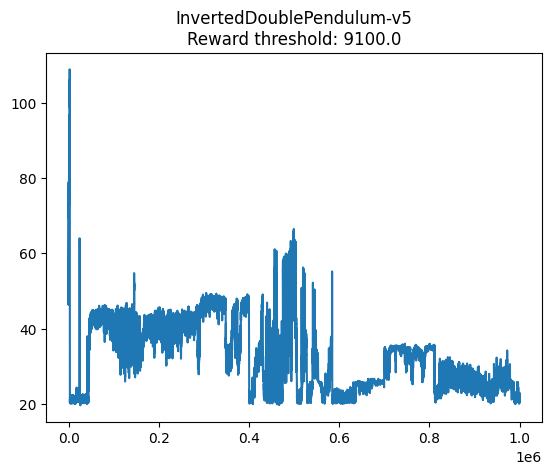

In [ ]:
smoothing_interval = 100 # Change for different levels of smoothing
smoothed_rewards = np.convolve(all_episode_rewards, np.ones(smoothing_interval)/smoothing_interval, 'valid')
plt.plot(smoothed_rewards)
plt.title(f"{env_name}\nReward threshold: {env.spec.reward_threshold}")

## Visualize the policy

In [ ]:
# Initialise the environment
env = gym.make(env_name, render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)

done = False
while not done:

    # For InvertedDoublePendulum-v5 the environment is terminated basically immediately
    # For better visibility, wait a bit between frames:
    time.sleep(1)

    pred_means, pred_stddevs = policy(torch.tensor(observation, requires_grad=False, dtype=torch.float32))
    action = pred_means # TODO: should sampling also be stochastic?

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action.detach().numpy())
    
    # If the episode has ended then we can reset to start a new episode
    done = terminated or truncated
    if done:
        observation, info = env.reset()

env.close()

## Evaluate the random policy

In [ ]:
# We evaluate the random policy by taking the average of the total reward over 100 episodes
# "Random" is being interpreted as env.action_space.sample(), which is the uniform distribution in case of a bounded interval:
# https://gymnasium.farama.org/api/spaces/fundamental/#gymnasium.spaces.Box.sample
# An alternative would be to sample from a randomly-initialized policy, 
# which corresponds to a mean 0 and standard deviation 1 truncated normal distribution on the action space.

evaluation_seed = 314

total_rewards = [] # total episode rewards

for i_episode in range(100):
    total_reward = 0
    env = gym.make(env_name, continuous=True) if env_name in ["LunarLander-v3", "CarRacing-v3"] else gym.make(env_name)
    observation, info = env.reset(seed=evaluation_seed)
    done = False
    while not done:
        action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done = terminated or truncated
        if done:
            observation, info = env.reset()

    total_rewards.append(total_reward)

env.close()

np.mean(total_rewards) # average reward for random policy

The random policies give these total rewards (approximately):

| Env_name | Average total reward of random policy |
| --- | ----------- |
| HalfCheetah-v5 | -286.2 |
| Hopper-v5 | 18.0 |
| InvertedDoublePendulum-v5 | 46.3 |
| InvertedPendulum-v5 | 4.7 |
| Reacher-v5 | -46.1 |
| Swimmer-v5 | 0.3 |
| Walker2d-v5 | 1.6 |

We need these numbers later to give a relative comparison between different algorithms.

## Results

I ran the above code for the 7 environments used in the PPO paper (code with minor modifications not shown here) for 10k episodes (we'll switch to counting environment steps in the next notebook), and the results are as follows:

<table>
  <tr>
    <td> <img src="../assets/REINFORCE_with_baseline_HalfCheetah-v5_10000episodes.png"> </td>
    <td> <img src="../assets/REINFORCE_with_baseline_Hopper-v5_10000episodes.png"> </td>
    <td> <img src="../assets/REINFORCE_with_baseline_InvertedDoublePendulum-v5_10000episodes.png"> </td>
    <td> <img src="../assets/REINFORCE_with_baseline_InvertedPendulum-v5_10000episodes.png"> </td>
  </tr>
  <tr>
    <td> <img src="../assets/REINFORCE_with_baseline_Reacher-v5_10000episodes.png"> </td>
    <td> <img src="../assets/REINFORCE_with_baseline_Swimmer-v5_10000episodes.png"> </td>
    <td> <img src="../assets/REINFORCE_with_baseline_Walker2d-v5_10000episodes.png"> </td>
  </tr>
</table>

Comparison to results given in the PPO paper, p7:
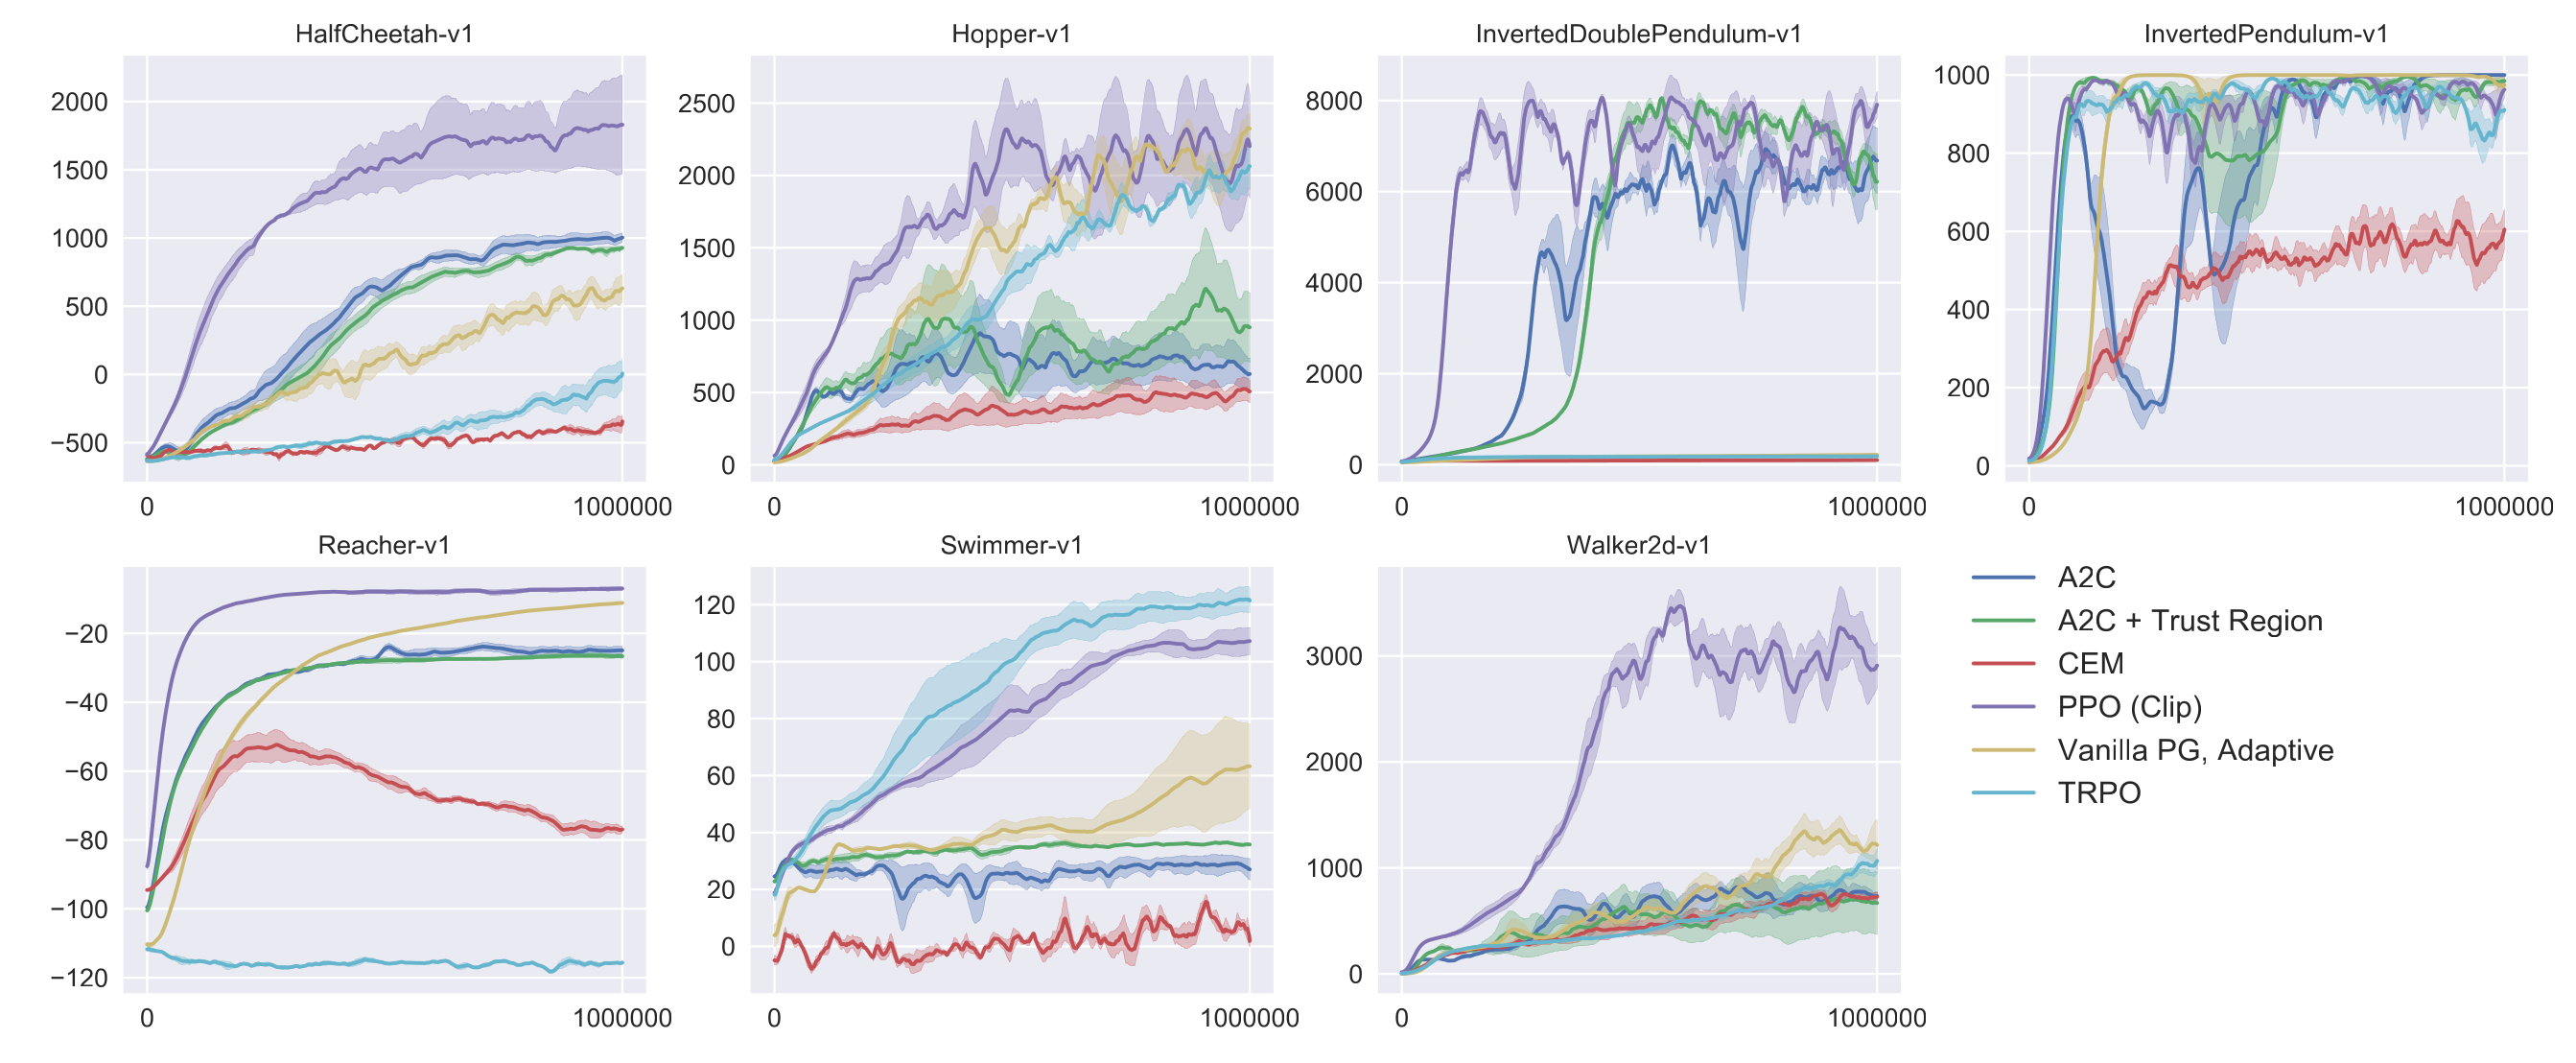

The results are roughly comparable to the yellow line, which is a policy gradient algorithm but with adaptive step-size (see [here](https://github.com/berkeleydeeprlcourse/homework/commit/730ea46cffbb720866e74e174fa8975461c3486e); we use constant step-size). For Hopper and Walker2D, our results are much worse though.